### Install modules in terminal

In [1]:
%pip install pandas scikit-learn numpy hmmlearn matplotlib joblib

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.5 MB 11.8 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.5 MB 11.8 MB/s eta 0:00:01
   ------------------------- -------------- 7.3/11.5 MB 11.9 MB/s eta 0:00:01
   --------------------------------- ------ 9.7/11.5 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.1 MB 11.9 MB/s eta 0:00:01
   ----------------- ---------------------- 4.7/11.1 MB 11.9 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 11.9 MB/s eta 0:00:01
   ----------------------------------- ---- 9.7/11.1 MB 11.9 MB/s eta 0:00:01
   ---------------------------


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import modules

In [2]:
import pandas as pd

import joblib
import numpy as np

import hmmlearn.hmm
from hmmlearn.hmm import MultinomialHMM, GaussianHMM

import matplotlib.pyplot as plt

### HMM Model with 2024 data

In [3]:
training_df = pd.read_csv("../datasets/BTCUSDT_train_features.csv")

print(training_df)


                 timestamp      open      high       low     close  \
0      2018-01-01 17:00:00  13093.10  13248.60  13093.09  13138.11   
1      2018-01-01 18:00:00  13138.12  13321.23  13114.47  13189.98   
2      2018-01-01 19:00:00  13189.98  13350.00  13156.91  13345.47   
3      2018-01-01 20:00:00  13345.47  13544.24  13345.46  13469.01   
4      2018-01-01 21:00:00  13469.01  13772.59  13432.00  13565.00   
...                    ...       ...       ...       ...       ...   
26942  2021-01-29 11:00:00  36686.34  37307.28  36491.79  37108.69   
26943  2021-01-29 12:00:00  37106.18  37988.28  36622.22  37967.31   
26944  2021-01-29 13:00:00  37967.74  38570.13  37171.79  38458.99   
26945  2021-01-29 14:00:00  38499.99  38534.47  36570.00  37185.49   
26946  2021-01-29 15:00:00  37185.49  37619.92  36868.50  37178.27   

            volume        rsi         macd        ema_12        ema_26  \
0       380.269338  35.795321  -191.147212  13323.908819  13515.056031   
1       552

In [4]:
# Load your data
df = training_df

# Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by time just in case
df = df.sort_values('timestamp')

# Drop NaN from the first row (due to shift)
df = df.dropna()

# Prepare observation sequence (log returns and normalized volume)
df['volume_norm'] = (df['volume'] - df['volume'].mean()) / df['volume'].std()
df['rsi_norm'] = (df['rsi'] - df['rsi'].mean()) / df['rsi'].std()
df['macd_norm'] = (df['macd'] - df['macd'].mean()) / df['macd'].std()
df['ema12_norm'] = (df['ema_12'] - df['ema_12'].mean()) / df['ema_12'].std()
df['ema26_norm'] = (df['ema_26'] - df['ema_26'].mean()) / df['ema_26'].std()
df['sma20_norm'] = (df['sma_20'] - df['sma_20'].mean()) / df['sma_20'].std()
df['volatility_norm'] = (df['volatility'] - df['volatility'].mean()) / df['volatility'].std()

df = df.dropna()

observations = df[['log_return', 'volume_norm', 'rsi_norm', 'macd_norm', 'ema12_norm', 'ema26_norm', 'sma20_norm', 'volatility_norm']].values

# Fit a Gaussian HMM with N hidden states
hmmodel = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000) 
hmmodel.fit(observations)

# Predict the hidden states
hidden_states = hmmodel.predict(observations)

# Add hidden states to dataframe
df['state'] = hidden_states

print(df[['timestamp', 'open', 'close', 'log_return', 'state']])


Model is not converging.  Current: 393136.5175567118 is not greater than 393136.580355316. Delta is -0.06279860419454053


                timestamp      open     close  log_return  state
0     2018-01-01 17:00:00  13093.10  13138.11    0.003432      0
1     2018-01-01 18:00:00  13138.12  13189.98    0.003940      0
2     2018-01-01 19:00:00  13189.98  13345.47    0.011720      0
3     2018-01-01 20:00:00  13345.47  13469.01    0.009214      0
4     2018-01-01 21:00:00  13469.01  13565.00    0.007101      0
...                   ...       ...       ...         ...    ...
26942 2021-01-29 11:00:00  36686.34  37108.69    0.011150      1
26943 2021-01-29 12:00:00  37106.18  37967.31    0.022874      1
26944 2021-01-29 13:00:00  37967.74  38458.99    0.012867      1
26945 2021-01-29 14:00:00  38499.99  37185.49   -0.033674      1
26946 2021-01-29 15:00:00  37185.49  37178.27   -0.000194      1

[26947 rows x 5 columns]


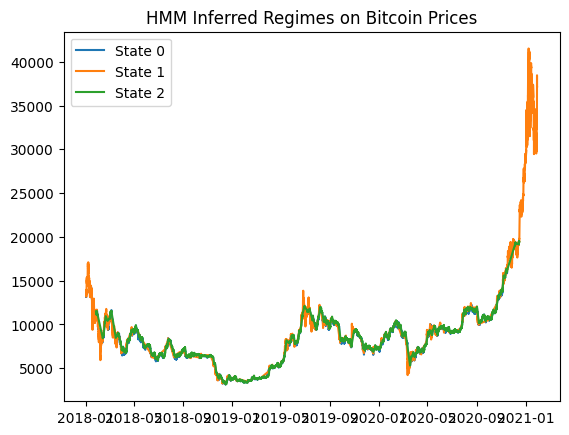

In [5]:
for i in range(hmmodel.n_components):
    state_series = df[df['state'] == i]
    plt.plot(state_series['timestamp'], state_series['close'], label=f'State {i}')

    #the state 0 represents a bear market (steady growth with low volatility) and state 1 represents a bull market (downward trend and high volatility)

plt.legend()
plt.title("HMM Inferred Regimes on Bitcoin Prices")
plt.show()

### Identify the meaning of the state number

In [6]:
# Calculate average return, volatility, and volume per state
state_analysis = df.groupby('state').agg({
    'log_return': ['mean', 'std'],
    'volume_norm': 'mean',
    'rsi_norm': 'mean',
    'macd_norm': 'mean',
    'ema12_norm': 'mean',
    'ema26_norm': 'mean',
    'sma20_norm': 'mean',
    'volatility_norm': 'mean'
})

# Calculate the relative frequency (percentage) of each state
state_percentages = df['state'].value_counts(normalize=True) * 100

print("Percentage of each state:")
print(state_percentages)


print("\n=== State Analysis (to identify the meaning of each state, the highest the log return, the market is bullish) === ")
print(state_analysis)

# Determine which state is most bullish (highest average return)
bullish_state = state_analysis['log_return']['mean'].idxmax()
print("\nState considered Bullish =", bullish_state)

# Determine which state is most bearish (lowest average return)
bearish_state = state_analysis['log_return']['mean'].idxmin()
print("State considered Bearish =", bearish_state)

# Determine the Neutral state (neither max nor min return)
neutral_state = list(set(df['state'].unique()) - {bullish_state, bearish_state})[0]
print("State considered Neutral =", neutral_state)

# Add market_state labels based on analysis
state_mapping = {
    bullish_state: 'bullish',
    bearish_state: 'bearish',
    neutral_state: 'neutral'
}
df['market_state'] = df['state'].map(state_mapping)
print(df[['timestamp', 'open', 'close', 'log_return', 'state', 'market_state']])


Percentage of each state:
state
2    47.066464
0    32.905333
1    20.028204
Name: proportion, dtype: float64

=== State Analysis (to identify the meaning of each state, the highest the log return, the market is bullish) === 
      log_return           volume_norm  rsi_norm macd_norm ema12_norm  \
            mean       std        mean      mean      mean       mean   
state                                                                   
0      -0.000256  0.006986   -0.043937 -0.612323 -0.285526  -0.174596   
1       0.000318  0.016702    1.008481  0.270581  0.238522   1.056292   
2       0.000126  0.002995   -0.398421  0.312950  0.098120  -0.327420   

      ema26_norm sma20_norm volatility_norm  
            mean       mean            mean  
state                                        
0      -0.168819  -0.168502       -0.148950  
1       1.054369   1.053678        1.268460  
2      -0.330640  -0.330568       -0.435633  

State considered Bullish = 1
State considered Bearish = 0


### Simple Prediction Example

In [7]:
# # Example data
# today_close = 44957.63
# yesterday_close = 44122.03
# today_vol = 46593616092.15278
volume_mean = df['volume'].mean()
volume_std = df['volume'].std()

rsi_mean = df['rsi'].mean()
rsi_std = df['rsi'].std()

macd_mean = df['macd'].mean()
macd_std = df['macd'].std()

ema12_mean = df['ema_12'].mean()
ema12_std = df['ema_12'].std()

ema26_mean = df['ema_26'].mean()
ema26_std = df['ema_26'].std()

sma20_mean = df['sma_20'].mean()
sma20_std = df['sma_20'].std()

volatility_mean = df['volatility'].mean()
volatility_std = df['volatility'].std()

# # Calculate features
# log_return = np.log(today_close / yesterday_close)
# volume_norm = (today_vol - volume_mean) / volume_std

# # Format as 2D array
# new_obs = np.array([[log_return, volume_norm]])

# # Predict hidden state
# state_today = hmmodel.predict(new_obs)

# print(f"Predicted hidden state: {state_today[0]}")

def HMM_predictor(today_close, yesterday_close, today_vol, today_rsi, today_macd, today_ema12, today_ema26, today_sma20, today_volatility):

    # Calculate features
    log_return = np.log(today_close / yesterday_close)
    volume_norm = (today_vol - volume_mean) / volume_std
    rsi_norm = (today_rsi - rsi_mean) / rsi_std
    macd_norm = (today_macd - macd_mean) / macd_std
    ema12_norm = (today_ema12 - ema12_mean) / ema12_std
    ema26_norm = (today_ema26 - ema26_mean) / ema26_std
    sma20_norm = (today_sma20 - sma20_mean) / sma20_std
    volatility_norm = (today_volatility - volatility_mean) / volatility_std

    # Format as 2D array
    new_obs = np.array([[log_return, volume_norm, rsi_norm, macd_norm, ema12_norm, ema26_norm, sma20_norm, volatility_norm]])

    # Predict hidden state
    state_today = hmmodel.predict(new_obs)

    return state_today[0]

joblib.dump(hmmodel, '../models/hmm.pkl')


['../models/hmm.pkl']